In [30]:
!git clone https://github.com/ProKampas/self-driving-car.git


Cloning into 'self-driving-car'...
remote: Enumerating objects: 15481, done.
remote: Counting objects: 100% (15481/15481), done.
remote: Compressing objects: 100% (15480/15480), done.
remote: Total 50797 (delta 2), reused 15478 (delta 1), pack-reused 35316
Receiving objects: 100% (50797/50797), 734.03 MiB | 38.28 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (12659/12659), done.


In [51]:
import os
import ntpath

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2

import pandas as pd
import random

from imgaug import augmenters as iaa

In [32]:
data_dir = 'self-driving-car/Udacity_Train_Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\center_2020_12_26_15_04_20_022.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\left_2020_12_26_15_04_20_022.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\right_2020_12_26_15_04_20_022.jpg,0.000000,0.0,0.0,0.000079
1,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\center_2020_12_26_15_04_20_126.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\left_2020_12_26_15_04_20_126.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\right_2020_12_26_15_04_20_126.jpg,0.000000,0.0,0.0,0.000085
2,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\center_2020_12_26_15_04_20_228.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\left_2020_12_26_15_04_20_228.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\right_2020_12_26_15_04_20_228.jpg,0.000000,0.0,0.0,0.000079
3,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\center_2020_12_26_15_04_20_330.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\left_2020_12_26_15_04_20_330.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\right_2020_12_26_15_04_20_330.jpg,-0.161302,0.0,0.0,0.000085
4,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\center_2020_12_26_15_04_20_432.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\left_2020_12_26_15_04_20_432.jpg,C:\Users\prote\Documents\Udemy\The Complete Self-Driving Car Course\self-driving-car\Udacity_Train_Data\IMG\right_2020_12_26_15_04_20_432.jpg,-0.453181,0.0,0.0,0.000094


In [33]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail


In [34]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].vapply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_12_26_15_04_20_022.jpg,left_2020_12_26_15_04_20_022.jpg,right_2020_12_26_15_04_20_022.jpg,0.000000,0.0,0.0,0.000079
1,center_2020_12_26_15_04_20_126.jpg,left_2020_12_26_15_04_20_126.jpg,right_2020_12_26_15_04_20_126.jpg,0.000000,0.0,0.0,0.000085
2,center_2020_12_26_15_04_20_228.jpg,left_2020_12_26_15_04_20_228.jpg,right_2020_12_26_15_04_20_228.jpg,0.000000,0.0,0.0,0.000079
3,center_2020_12_26_15_04_20_330.jpg,left_2020_12_26_15_04_20_330.jpg,right_2020_12_26_15_04_20_330.jpg,-0.161302,0.0,0.0,0.000085
4,center_2020_12_26_15_04_20_432.jpg,left_2020_12_26_15_04_20_432.jpg,right_2020_12_26_15_04_20_432.jpg,-0.453181,0.0,0.0,0.000094


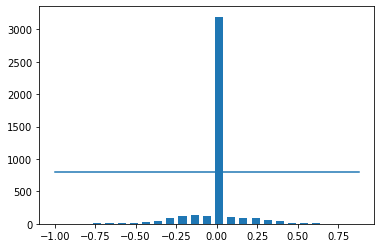

In [35]:
num_bins = 25
samples_per_bin = 800

hist, bins = np.histogram(data['steering'], num_bins)

center = (bins[:-1] + bins[1:]) / 2.0

plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total:  4219
removed:  2396
Remaining:  1823


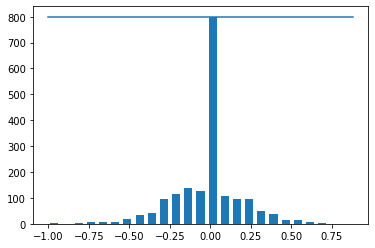

In [36]:
print('total: ', len(data))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j]  and  data['steering'][i] < bins[j+1]:
      list_.append(i)
    
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]

  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)

print('Remaining: ', len(data))

hist, _ = np.histogram(data['steering'], num_bins)

plt.bar(center, hist, width=0.05)

plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [37]:
def load_dataset(dir, df):
  imgs = []
  steering = []

  for i in range(len(df)):
    indx_data = df.iloc[i]
    
    center, left, right = indx_data[0], indx_data[1], indx_data[2]

    choice = np.random.choice(3)

    if choice == 0:
      imgs.append(os.path.join(dir, center.strip()))
      steering.append(float(indx_data[3]))
    elif choice == 1:
      imgs.append(os.path.join(dir, left.strip()))
      steering.append(float(indx_data[3]) + 0.2)
    else:
      imgs.append(os.path.join(dir, right.strip()))
      steering.append(float(indx_data[3]) - 0.2)

  imgs = np.asarray(imgs)
  steering = np.asarray(steering)

  return imgs, steering

In [38]:
imgs, steering = load_dataset(data_dir + '/IMG', data)

X_train, X_val, y_train, y_val = train_test_split(imgs, steering, test_size=0.2, random_state=6)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1458,) (365,) (1458,) (365,)


(array([ 1.,  0.,  0.,  1.,  3.,  2.,  4.,  9., 10.,  9., 70., 25., 18.,
        84., 17., 68.,  8., 13.,  7.,  8.,  2.,  1.,  2.,  2.,  1.]),
 array([-1.        , -0.9242252 , -0.84845039, -0.77267559, -0.69690078,
        -0.62112598, -0.54535118, -0.46957637, -0.39380157, -0.31802676,
        -0.24225196, -0.16647716, -0.09070235, -0.01492755,  0.06084726,
         0.13662206,  0.21239686,  0.28817167,  0.36394647,  0.43972128,
         0.51549608,  0.59127088,  0.66704569,  0.74282049,  0.8185953 ,
         0.8943701 ]),
 <a list of 25 Patch objects>)

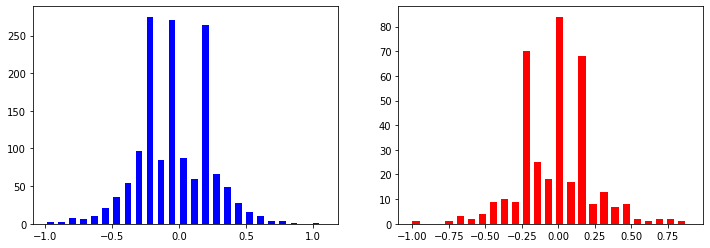

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].hist(y_train, bins=25, width=0.05, color='blue')
axes[1].hist(y_val, bins=25, width=0.05, color='red')

In [40]:
def zoom(img):
  zoom = iaa.Affine(scale=(1.0, 1.3))
  img = zoom.augment_image(img)
  return img

def pan(img):
  pan = iaa.Affine(translate_percent= {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  img = pan.augment_image(img)
  return img

def brightness(img):
  brightness = iaa.Multiply(mul=(0.2, 1.2))
  img = brightness.augment_image(img)
  return img

def flip(img, steering_angle):
  img = cv2.flip(img, 1)
  steering_angle = -steering_angle
  return img, steering_angle

def rand_augment(img, steering_angle):

  if np.random.rand() < 0.5:
    img = zoom(img)
  if np.random.rand() < 0.5:
    img = pan(img)
  if np.random.rand() < 0.5:
    img = brightness(img)
  if np.random.rand() < 0.5:
    img, steering_angle = flip(img, steering_angle)
  
  return img, steering_angle
  

In [41]:
def batch_generator(img_paths, steer_angles, batch_size, is_training):

  while True:
    batch_imgs = []
    batch_steers = []

    for i in range(batch_size):
      random_index = random.randint(0, len(img_paths) - 1)

      img = mpimg.imread(img_paths[random_index])

      if is_training and np.random.rand() < 0.6:
        img, steer_angle = rand_augment(img=img, steering_angle=steer_angles[random_index])
      else:  
        steer_angle = steer_angles[random_index]
      
      img = img_preprocess(img)

      batch_imgs.append(img)
      batch_steers.append(steer_angle) 

    yield (np.asarray(batch_imgs), np.asarray(batch_steers))

In [42]:
def img_preprocess(img):
  img = img[50:135, :, :]

  img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)  
  img = cv2.resize(img, (200, 66))

  img = img/127.5 - 1

  return img

In [44]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='elu'))

  model.add(Dropout(rate=0.5))

  model.add(Flatten())

  model.add(Dense(units=100, activation='elu'))
  # model.add(Dropout(rate=0.5))
  model.add(Dense(units=50, activation='elu'))
  # model.add(Dropout(rate=0.5))

  model.add(Dense(units=10, activation='elu'))
  # model.add(Dropout(rate=0.5))

  model.add(Dense(units=1))

  model.compile(optimizer=Adam(lr=0.0001), loss='mse')

  return model

In [45]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [46]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                              monitor='val_loss',
                              verbose=0,
                              save_best_only='true',
                              mode='auto')

# h = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=100, verbose=1, shuffle=True)

h = model.fit_generator(batch_generator(X_train, y_train, 40, True), 
                        steps_per_epoch=2000,
                        epochs=10, 
                        validation_data=batch_generator(X_val, y_val, 40, False), 
                        validation_steps=200,
                        verbose=1, 
                        shuffle=True,
                        callbacks=[checkpoint])

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 335s 167ms/step - loss: 0.0382 - val_loss: 0.0236
Epoch 2/10
2000/2000 [==============================] - 333s 167ms/step - loss: 0.0247 - val_loss: 0.0229
Epoch 3/10
2000/2000 [==============================] - 332s 166ms/step - loss: 0.0203 - val_loss: 0.0235
Epoch 4/10
2000/2000 [==============================] - 340s 170ms/step - loss: 0.0185 - val_loss: 0.0239
Epoch 5/10
2000/2000 [==============================] - 335s 168ms/step - loss: 0.0167 - val_loss: 0.0225
Epoch 6/10
2000/2000 [==============================] - 332s 166ms/step - loss: 0.0154 - val_loss: 0.0241
Epoch 7/10
2000/2000 [==============================] - 341s 170ms/step - loss: 0.0147 - val_loss: 0.0225
Epoch 8/10
2000/2000 [==============================] - 336s 168ms/step - loss: 0.0137 - val_loss: 0.0247
Epoch 9/10
2000/2000 [==============================] - 338s 169ms/step - loss: 0.0141 - val_loss: 0.0230
Epoch 10/10
2000/2000 [==============================] - 

Text(0.5, 0, 'epoch')

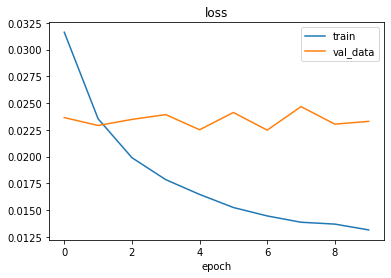

In [47]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['train', 'val_data'])
plt.title('loss')
plt.xlabel('epoch')

In [48]:
model.save('model.h5')

In [49]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>